In [1]:
from IPython.core.debugger import set_trace
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import time
import re
import string
import nltk
import tensorflow as tf
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from collections import Counter
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.initializers import Constant
from keras.optimizers import Adam
plt.style.use(style="seaborn")
%matplotlib inline

### Loading the Data

In [2]:
csv_file_path = ('data/kickstarter_data_with_features.csv')
dataframe = pd.read_csv(csv_file_path)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (29,30,31,32) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Defining  some functions

In [3]:
# Multiple functions for cleaning data 

def remove_URL(text):
    url = re.compile(r"https?://\S+|www\.\S+")
    return url.sub(r"", text)


def remove_html(text):
    html = re.compile(r"<.*?>")
    return html.sub(r"", text)

def remove_number(text):
    newstring = re.sub(r'[0-9]+', '', text)
    return newstring


def remove_emoji(string):
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+",
        flags=re.UNICODE,
    )
    return emoji_pattern.sub(r"", string)


def remove_punct(text):
    table = str.maketrans("", "", string.punctuation)
    return text.translate(table)

def remove_stopwords(text):
    # nltk.download('stopwords') 
    stop = set(stopwords.words("english"))
    text = [word.lower() for word in text.split() if word.lower() not in stop]

    return " ".join(text)


def get_vocab_size(text):
    """Count unique words"""
    count = Counter()
    for i in text.values:
        i = remove_punct(i)
        i = remove_emoji(i)
        i = remove_URL(i)
        i = remove_html(i)
        i = remove_number(i)
        for word in i.split():
            count[word] += 1
    return len(count)

### Preprocessing the data

In [4]:
dataframe['blurb']=dataframe['blurb'].astype("string") 
dataframe = dataframe[['blurb','state']] # only using these 2 cols
dataframe = dataframe[dataframe['state'].isin(['successful', 'failed'])]
dataframe['state'] = dataframe['state'].replace({'failed': 0, 'successful': 1})
dataframe['blurb'] = dataframe['blurb'].map(remove_stopwords) # remove stop words
dataframe = dataframe.dropna() 

### Splitting the Data

In [5]:
from sklearn.model_selection import train_test_split
X = dataframe.drop('state', axis=1)
Y = dataframe.state
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.3, random_state=123)

### Getting the Vocabular size: # of unique words

In [6]:
train_v_size = get_vocab_size(X_train.blurb)

In [7]:
train_v_size

23927

### Sequencing the text

Fitting a tokenizer to assign indices to words and converting the text to sequence of indices.

In [8]:
#fit tokenizer on training data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train.blurb)
#get train sequences
train_seqs = tokenizer.texts_to_sequences(X_train.blurb)
train_seqs_max_size = max([len(seq) for seq in train_seqs])
#get test sequences
test_seqs = tokenizer.texts_to_sequences(X_test.blurb)
test_seqs_max_size = max([len(seq) for seq in test_seqs])

In [121]:
train_seqs_max_size, test_seqs_max_size

(26, 23)

### Padding the sequences

Padding the sequences to have seqencies of equal length. 

In [122]:
train_padded = pad_sequences(train_seqs, maxlen=train_seqs_max_size, padding="post", truncating="post")
test_padded = pad_sequences(test_seqs, maxlen=train_seqs_max_size, padding="post", truncating="post")

In [123]:
print(f"Shape of train {train_padded.shape}")
print(f"Shape of test {test_padded.shape}")

Shape of train (12203, 26)
Shape of test (5231, 26)


### Embeddings

In [92]:
documents = X_train.blurb
X_train_tokenized = [[word for word in document.lower().split()] for document in documents]

#### Word2Vec

In [129]:
from gensim.models import Word2Vec, FastText
word_model = Word2Vec(X_train_tokenized, vector_size=100)

#build matrix 
embedding_matrix_w2v = np.random.random(((train_v_size) + 1, 100))
for word,i in tokenizer.word_index.items():  
    try:
        embedding_matrix_ft[i] = word_model.wv[word]
    except:
        pass

# create layer
embedding_layer_w2v = Embedding((train_v_size) + 1, output_dim=100, 
                            weights=[embedding_matrix_w2v], trainable=False)

#### FastText

In [144]:
ft = FastText(vector_size=100)
ft.build_vocab(tokenizer.word_index)
ft.train(tokenizer.word_index, total_examples=ft.corpus_count, epochs=10)

# build matrix
embedding_matrix_ft = np.random.random((len(tokenizer.word_index) + 1, ft.vector_size))
for word,i in tokenizer.word_index.items(): 
    try:
        embedding_matrix_ft[i] = ft.wv[word]
    except:
        pass

# create layer
embedding_layer_ft = Embedding(len(tokenizer.word_index) + 1, output_dim=100, 
                            weights=[embedding_matrix_ft], trainable=False)

### Modeling

In [145]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.initializers import Constant
from keras.optimizers import Adam

model = Sequential()

# model.add(Embedding(train_v_size, output_dim=100, input_length=train_seqs_max_size))
# model.add(embedding_layer_w2v)
model.add(embedding_layer_ft)

model.add(LSTM(20, dropout=.9))
model.add(Dense(1, activation="sigmoid"))


optimizer = Adam(learning_rate=3e-4)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [146]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, None, 100)         2310200   
_________________________________________________________________
lstm_9 (LSTM)                (None, 20)                9680      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 21        
Total params: 2,319,901
Trainable params: 9,701
Non-trainable params: 2,310,200
_________________________________________________________________


In [147]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [148]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(
    train_padded, y_train, epochs=10, validation_data=(test_padded, y_test),
    callbacks=[early_stopping],

)

Epoch 1/10
382/382 [==============================] - 7s 14ms/step - loss: 0.6766 - accuracy: 0.5937 - val_loss: 0.7117 - val_accuracy: 0.6492
Epoch 2/10
382/382 [==============================] - 5s 12ms/step - loss: 0.6501 - accuracy: 0.6547 - val_loss: 0.6803 - val_accuracy: 0.6492
Epoch 3/10
382/382 [==============================] - 5s 13ms/step - loss: 0.6510 - accuracy: 0.6542 - val_loss: 0.6646 - val_accuracy: 0.6492
Epoch 4/10
382/382 [==============================] - 5s 13ms/step - loss: 0.6475 - accuracy: 0.6554 - val_loss: 0.6622 - val_accuracy: 0.6492
Epoch 5/10
382/382 [==============================] - 6s 16ms/step - loss: 0.6496 - accuracy: 0.6543 - val_loss: 0.6595 - val_accuracy: 0.6492
Epoch 6/10
382/382 [==============================] - 5s 13ms/step - loss: 0.6461 - accuracy: 0.6561 - val_loss: 0.6575 - val_accuracy: 0.6492
Epoch 7/10
382/382 [==============================] - 5s 13ms/step - loss: 0.6469 - accuracy: 0.6575 - val_loss: 0.6554 - val_accuracy: 0.6492

In [149]:
results = model.evaluate(test_padded, y_test, batch_size=128)

41/41 [==============================] - 0s 7ms/step - loss: 0.6526 - accuracy: 0.6492


In [150]:
metrics_df = pd.DataFrame(history.history)
metrics_df

,loss,accuracy,val_loss,val_accuracy
0,0.661227,0.628862,0.711713,0.649207
1,0.652848,0.652872,0.680306,0.649207
2,0.649917,0.654593,0.664623,0.649207
3,0.647773,0.657461,0.662218,0.649207
4,0.646537,0.657052,0.659550,0.649207
5,0.645362,0.657215,0.657526,0.649207
6,0.646842,0.657215,0.655406,0.649207
7,0.645787,0.657461,0.655514,0.649207
8,0.645383,0.657215,0.651899,0.649207
9,0.643995,0.657297,0.652597,0.649207


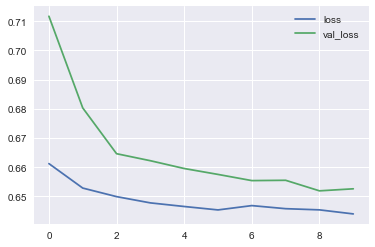

In [151]:
metrics_df[["loss","val_loss"]].plot();
#### OVERFITTING!

#### References

https://radimrehurek.com/gensim/models/word2vec.html